In [ ]:
!python3 -c "import lightning" || pip install lightning==2.2.4
!python3 -c "import torchsummary" || pip install torchsummary

In [4]:
from collections import OrderedDict
from torchvision import models
from torch import nn
from torch.utils.data import Dataset
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor
import lightning as L
import torch
import os
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
from skimage import data, io
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances, confusion_matrix, accuracy_score, precision_recall_fscore_support, cohen_kappa_score, matthews_corrcoef, balanced_accuracy_score, classification_report

import seaborn as sns
import random
from torchvision.transforms import v2
from PIL import Image, ImageOps

import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as TVF
from torchsummary import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from lightning.pytorch.loggers import CSVLogger

In [5]:
print(torch.cuda.get_arch_list())

['sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'sm_37', 'sm_90']


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
device

device(type='cuda')

In [8]:
OBJECTS_ROOT = r"/home/shared/datasets/pollen_dataset_2024_05_08_objects_clear/pollen_dataset_2024_05_08_objects"

In [9]:
random.seed(42)

In [10]:
def pad2size(image, size=(224, 224)):
    return ImageOps.fit(image, size)

class PollenTripletDataset(Dataset):
    def __init__(self, img_dir, classes, 
                 static_transform=None, 
                 random_transform=None,
                 inflation_rate=1):
        self.known_classes = classes
        self.known_classes_numbers = list(range(len(classes)))
        self.known_classes.sort()
        self.transform = random_transform
        self._all_samples = []
        self._all_classes_dict = {}
        self._class_to_indices = {i: [] for i,c in enumerate(self.known_classes)}
        total_samples = 0
        for c in tqdm(self.known_classes):
            c_number = len(self._all_classes_dict)
            self._all_classes_dict[c_number] = c
            images = glob(os.path.join(img_dir, c, "*.png"))
            print(f"{len(images)} samples in the class {c}")
            
            for idx, img_path in enumerate(tqdm(images)):
                img = Image.open(img_path)
                if static_transform is not None:
                    img = static_transform(img)
                self._all_samples.append((c_number, img))
                self._class_to_indices[c_number].append(total_samples)
                total_samples += 1
        
        print(f"Total samples: {total_samples}")

    def __len__(self):
        return len(self._all_samples)

    def __getitem__(self, idx):
        label, anchor = self._all_samples[idx]
        label_str = self._all_classes_dict[label]
        
        positive_idx = random.choice(self._class_to_indices[label])
        positive = self._all_samples[positive_idx][1]
        
        neg_classes = [c for c in self.known_classes_numbers if c != label]
        negative_class = random.choice(neg_classes)
        negative_idx = random.choice(self._class_to_indices[negative_class])
        negative_label, negative = self._all_samples[negative_idx]
        negative_str = self._all_classes_dict[negative_label]
        
        if self.transform:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)
        
        anchor = torch.as_tensor(anchor) if not isinstance(anchor, torch.Tensor) else anchor
        positive = torch.as_tensor(positive) if not isinstance(positive, torch.Tensor) else positive
        negative = torch.as_tensor(negative) if not isinstance(negative, torch.Tensor) else negative

        return anchor, positive, negative, label, label_str, negative_label, negative_str

known_classes = os.listdir(OBJECTS_ROOT)

print(f"All known classes: {known_classes}")
train_classes, test_classes = train_test_split(known_classes, test_size=0.2, random_state=42)
train_classes, val_classes = train_test_split(train_classes, test_size=0.2, random_state=42)

print(f"Train classes: {train_classes}")
print(f"Validation classes: {val_classes}")
print(f"Test classes: {test_classes}")

input_size=(224, 224)

static_transforms = v2.Compose([
    v2.Lambda(pad2size),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


print("\nLoad Train Dataset")
dataset_train = PollenTripletDataset(OBJECTS_ROOT, train_classes, static_transform=static_transforms, inflation_rate=100)
print("\nLoad Validation Dataset")
dataset_val = PollenTripletDataset(OBJECTS_ROOT, val_classes, static_transform=static_transforms, inflation_rate=100)
print("\nLoad Test Dataset")
dataset_test = PollenTripletDataset(OBJECTS_ROOT, test_classes, static_transform=static_transforms, inflation_rate=100)

All known classes: ['Alnus', 'Betula', 'Corylus', 'Acer', 'Pinus', 'Salix', 'Populus tremula', 'Tilia', 'Quercus']
Train classes: ['Acer', 'Quercus', 'Pinus', 'Corylus', 'Populus tremula']
Validation classes: ['Salix', 'Alnus']
Test classes: ['Tilia', 'Betula']

Load Train Dataset


  0%|          | 0/5 [00:00<?, ?it/s]

319 samples in the class Acer


  0%|          | 0/319 [00:00<?, ?it/s]

141 samples in the class Corylus


  0%|          | 0/141 [00:00<?, ?it/s]

67 samples in the class Pinus


  0%|          | 0/67 [00:00<?, ?it/s]

201 samples in the class Populus tremula


  0%|          | 0/201 [00:00<?, ?it/s]

90 samples in the class Quercus


  0%|          | 0/90 [00:00<?, ?it/s]

Total samples: 818

Load Validation Dataset


  0%|          | 0/2 [00:00<?, ?it/s]

25 samples in the class Alnus


  0%|          | 0/25 [00:00<?, ?it/s]

227 samples in the class Salix


  0%|          | 0/227 [00:00<?, ?it/s]

Total samples: 252

Load Test Dataset


  0%|          | 0/2 [00:00<?, ?it/s]

206 samples in the class Betula


  0%|          | 0/206 [00:00<?, ?it/s]

114 samples in the class Tilia


  0%|          | 0/114 [00:00<?, ?it/s]

Total samples: 320


In [11]:
def plot(imgs, row_title=None, labels=None, **imshow_kwargs):
    if labels != None:
        ax_title = True
    else:
        ax_title = False
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, tv_tensors.BoundingBoxes):
                    boxes = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = TVF.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            # print(img.unique())
            img = TVF.to_dtype(img, torch.uint8, scale=True)
            black_pixels = (img != 0).all(dim=0)
            img[:, ~black_pixels] = 255
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
            if ax_title:
                ax.set_title(labels[col_idx])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [12]:
train_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size= 48,
    shuffle= True,
    num_workers= 6
)
val_loader = torch.utils.data.DataLoader(
    dataset_val, 
    batch_size= 4,
    shuffle= True,
    num_workers= 6
)
test_loader = torch.utils.data.DataLoader(
    dataset_test, 
    batch_size= 1,
    shuffle= True,
    num_workers= 6
)

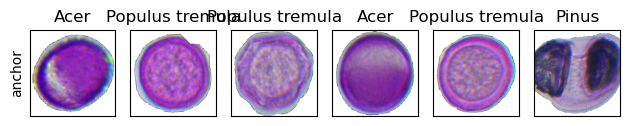

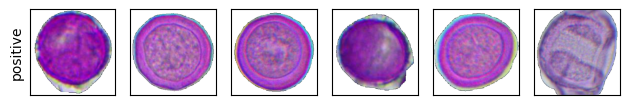

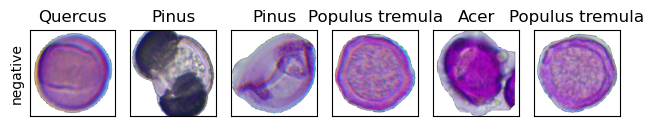

In [23]:
for anchor, positive, negative, label, label_str, negative_label, negative_str in train_loader:
    plot(anchor[:6], row_title=["anchor"], labels=label_str[:6])
    plot(positive[:6], row_title=["positive"])
    plot(negative[:6], row_title=["negative"], labels=negative_str[:6])
    break

In [93]:
class EmbeddingModel(nn.Module):
    def __init__(self, embedings=128):
        super().__init__()
        self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        self.embedings = nn.Linear(2048, embedings)
        self.model.fc = nn.Identity()

        self.classification = nn.Sequential(
            nn.Dropout(0.1),
            nn.GELU(),
            nn.Linear(embedings, 7),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        x = self.model(x)
        x = self.embedings(x)
        c = self.classification(x)
        x = nn.functional.normalize(x) # L2 normalization to put all values on a sphere
        return x, c

class PollenEmbedingsModule(L.LightningModule):
    def __init__(self,
                 optim_lr=0.001,
                 optim_betas=(0.9, 0.999),
                 optim_eps=1e-08,
                 optim_weight_decay=0,
                 check_val=20
                 ):
        super().__init__()
        # call this to save (arguments) to the checkpoint
        self.save_hyperparameters()

        self.loss_function = nn.TripletMarginLoss(margin=1.0, p=2, eps=1e-7)
        self.ce_loss = nn.CrossEntropyLoss()

        self.best_score = 0
        self.best_val_epoch = -1

        self.model = EmbeddingModel()

        self.validation_step_outputs = []

    def forward(self, inputs):
        return self.model(inputs)

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        anchor, positive, negative, label, _, _, _ = batch

        anchor_out, anchor_cls = self.model(anchor)
        positive_out, _ = self.model(positive)
        negative_out, _ = self.model(negative)
        ce_loss = self.ce_loss(anchor_cls, label)
        
        loss = self.loss_function(anchor_out, positive_out, negative_out)
        self.log("train_loss", loss + ce_loss)
        return loss + ce_loss

    def on_train_epoch_end(self):
        pass

    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        anchor, positive, negative, label, _, _, _ = batch

        anchor_out, anchor_cls = self.model(anchor)
        positive_out, _ = self.model(positive)
        negative_out, _ = self.model(negative)
        
        loss = self.loss_function(anchor_out, positive_out, negative_out)
        ce_loss = self.ce_loss(anchor_cls, label)

        pred = {"val_loss": loss + ce_loss, "val_number": len(anchor_out)}
        self.validation_step_outputs.append(pred)

    def on_validation_epoch_end(self):
        outputs = self.validation_step_outputs
        val_loss, num_items = 0, 0
        for output in outputs:
            val_loss += output["val_loss"].sum().item()
            num_items += output["val_number"]

        mean_val_loss = torch.tensor(val_loss / num_items)

        tensorboard_logs = {
            "val_loss": mean_val_loss
        }
        self.log("val_loss", mean_val_loss)
        self.validation_step_outputs.clear()  # free memory

        if mean_val_loss > self.best_score:
            self.best_score = mean_val_loss
            self.best_val_epoch = self.current_epoch

        return {"log": tensorboard_logs}

    def configure_optimizers(self):
        self.optimizer = torch.optim.Adam(self.parameters(),
                                          lr=self.hparams.optim_lr,
                                          betas=self.hparams.optim_betas,
                                          eps=self.hparams.optim_eps,
                                          weight_decay=self.hparams.optim_weight_decay)
        return {
            "optimizer": self.optimizer,
            "lr_scheduler": {
                "scheduler": ReduceLROnPlateau(self.optimizer, factor=0.1, patience=10),
                "frequency": self.hparams.check_val,
                "monitor": "val_loss",
                "interval": "epoch",
            }
        }

In [94]:
model = PollenEmbedingsModule(check_val=5)

In [95]:
model = model.to(device)
summary(model.model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [96]:
checkpoint_callback = ModelCheckpoint(
    filename='checkpoint-{epoch:02d}-{val_loss:.2f}',
    # auto_insert_metric_name=False,
    dirpath="./history",
    monitor='val_loss',
    mode='min')
lr_logger = LearningRateMonitor()
logger = CSVLogger("logs", name="triplet_1")

In [97]:
trainer = L.Trainer(logger=logger,
                    log_every_n_steps=1,  # Increase, if epoch size is large
                    callbacks=[checkpoint_callback, lr_logger],
                    precision="16-mixed",
                    check_val_every_n_epoch=model.hparams.check_val,
                    max_epochs=25,
                    accumulate_grad_batches=2,
                    )

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [98]:
trainer.fit(model, 
            train_dataloaders=train_loader, 
            val_dataloaders=val_loader,     
)

/opt/conda/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /home/jovyan/git/Pollen-Analyzer/Classification/history exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | loss_function | TripletMarginLoss | 0     
1 | ce_loss       | CrossEntropyLoss  | 0     
2 | model         | EmbeddingModel    | 23.8 M
----------------------------------------------------
23.8 M    Trainable params
0         Non-trainable params
23.8 M    Total params
95.085    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


## Loading the model

In [99]:
checkpoint_path = "/home/jovyan/git/Pollen-Analyzer/Classification/history/checkpoint-epoch=19-val_loss=0.58.ckpt"
model = PollenEmbedingsModule.load_from_checkpoint(checkpoint_path)

In [100]:
model.eval()
model = model.cuda()

In [101]:
def add_class_markings(ax, class_boundaries, labels):
    tick_locs = [(class_boundaries[i] + class_boundaries[i+1] - 1) / 2 for i in range(len(class_boundaries)-1)]
    ax.set_xticks(tick_locs)
    ax.set_yticks(tick_locs)
    ax.set_xticklabels([labels[int(loc)] for loc in tick_locs])
    ax.set_yticklabels([labels[int(loc)] for loc in tick_locs])
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    for boundary in class_boundaries[1:-1]:
        ax.axhline(y=boundary-1, color='k', linestyle='-', linewidth=1)
        ax.axvline(x=boundary-1, color='k', linestyle='-', linewidth=1)

In [102]:
def plot_matrix(embeddings_lists: list, labels_lists: list, subtitle: str=None, axes_class_markings: bool=True):
    all_labels_sorted, all_embeddings_sorted, class_boundaries = prepare_data(embeddings_lists, labels_lists)

    pairwise_dist = pairwise_distances(all_embeddings_sorted)
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(pairwise_dist, cmap='Blues_r')
    plt.colorbar(im)

    if axes_class_markings:
        add_class_markings(ax, class_boundaries, all_labels_sorted)

    if subtitle != None:
        plt.title('Pairwise Distance Matrix\n' + subtitle)
    else:
        plt.title('Pairwise Distance Matrix')
    plt.tight_layout()
    plt.show()
    del all_labels_sorted
    del all_embeddings_sorted
    del class_boundaries

In [103]:
def prepare_data(embeddings_lists: list, labels_lists: list):
    all_labels_sorted = []
    all_embeddings_sorted = []
    class_boundaries = [0]
    for i, embeddings_list in enumerate(embeddings_lists):
        labels_list = labels_lists[i]
        class_to_idx = {}
        for i, class_name in enumerate(np.unique(labels_list)):
            class_to_idx[class_name] = i
        all_labels_idx = [class_to_idx[label] for label in labels_list]
        sorted_indices = sorted(range(len(embeddings_list)), key=lambda i: all_labels_idx[i])
        start = len(all_labels_sorted) + 1
        all_embeddings_sorted.extend([embeddings_list[i] for i in sorted_indices])
        all_labels_sorted.extend([labels_list[i] for i in sorted_indices])
    
        for i in range(start, len(all_labels_sorted)):
            if all_labels_sorted[i] != all_labels_sorted[i-1]:
                class_boundaries.append(i)
        class_boundaries.append(len(all_labels_sorted))

    return all_labels_sorted, all_embeddings_sorted, class_boundaries

In [104]:
def process_loader(model, loader, class_names_dict, current_index, step, pred_label_data, label_data):
    all_embeddings = []
    all_labels = []
    updater = lambda t: t + step
    with torch.no_grad():
        for batch in loader:
            imgs, _, _, labels, labels_str, _, _ = batch
            for label in labels_str:
                if label not in class_names_dict:
                    class_names_dict[label] = current_index
                    current_index += 1
            imgs = imgs.cuda()
            embeddings, cls = model(imgs)
            all_embeddings.append(embeddings.cpu())
            all_labels.extend(labels_str)
            cls_upd = np.array([updater(xi) for xi in torch.argmax(cls, dim=1).cpu().numpy()])
            pred_label_data.extend(cls_upd)
            label_upd = np.array([updater(xi) for xi in labels.cpu().numpy()])
            label_data.extend(label_upd)
        all_embeddings = torch.cat(all_embeddings, dim=0).cpu().numpy()
    return all_embeddings, all_labels, current_index, pred_label_data, label_data

In [105]:
def process_data(model, loaders_list: list):
    embeddings_data = []
    labels_data_str = []
    pred_label_data = []
    label_data = []
    step = 0
    class_names_dict = OrderedDict()
    current_index = 0
    updater = lambda t: t + step
    for loader in tqdm(loaders_list):
        all_embeddings, all_labels, current_index, pred_label_data, label_data = process_loader(model, loader, class_names_dict, current_index, step, pred_label_data, label_data)
        embeddings_data.append(all_embeddings)
        labels_data_str.append(all_labels)
        step += np.unique(all_labels).size
        del all_embeddings
        del all_labels
    class_names = [k for k, _ in sorted(class_names_dict.items(), key=lambda item: item[1])]
    return embeddings_data, labels_data_str, pred_label_data, label_data, class_names

In [106]:
loaders_list = [test_loader, val_loader, train_loader]
embeddings_data, labels_data_str, pred_label_data, label_data, class_names = process_data(model, loaders_list)

  0%|          | 0/3 [00:00<?, ?it/s]

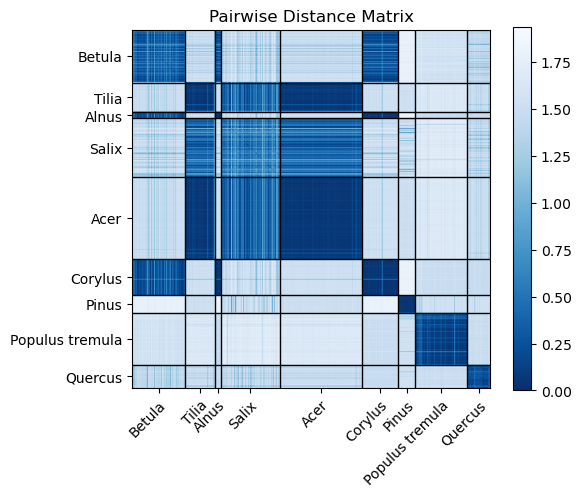

In [107]:
plot_matrix(embeddings_data, labels_data_str)

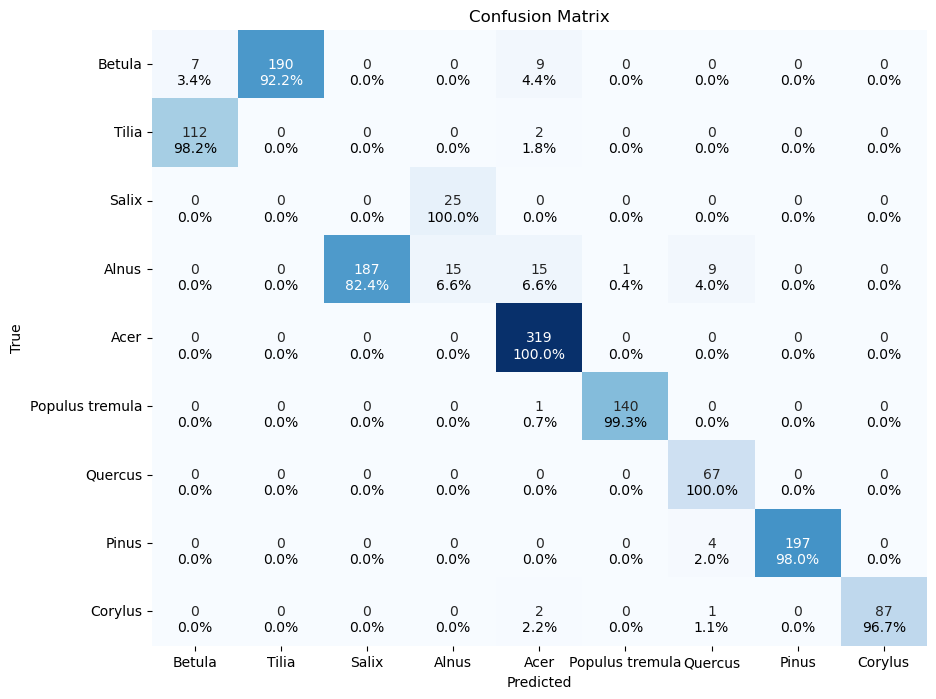

In [108]:
cm = confusion_matrix(label_data, pred_label_data)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            annot_kws={"size": 10}, cbar=False)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j+0.5, i+0.5, f'\n\n{cm_percent[i, j]:.1f}%',
                 ha="center", va="center",
                 color="white" if cm[i, j] > cm.max()/2 else "black")

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [109]:
accuracy = accuracy_score(label_data, pred_label_data)

precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(label_data, pred_label_data, average='macro')
precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(label_data, pred_label_data, average='micro')
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(label_data, pred_label_data, average='weighted')

kappa = cohen_kappa_score(label_data, pred_label_data)
mcc = matthews_corrcoef(label_data, pred_label_data)
balanced_acc = balanced_accuracy_score(label_data, pred_label_data)

report = classification_report(label_data, pred_label_data, target_names=class_names)

print(f"Accuracy: {accuracy:.4f}")
print(f"Macro Precision: {precision_macro:.4f}, Recall: {recall_macro:.4f}, F1: {f1_macro:.4f}")
print(f"Micro Precision: {precision_micro:.4f}, Recall: {recall_micro:.4f}, F1: {f1_micro:.4f}")
print(f"Weighted Precision: {precision_weighted:.4f}, Recall: {recall_weighted:.4f}, F1: {f1_weighted:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"Matthews Correlation Coefficient: {mcc:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print("\nClassification Report:")
print(report)

Accuracy: 0.5986
Macro Precision: 0.5745, Recall: 0.5600, F1: 0.5537
Micro Precision: 0.5986, Recall: 0.5986, F1: 0.5986
Weighted Precision: 0.6303, Recall: 0.5986, F1: 0.5954
Cohen's Kappa: 0.5406
Matthews Correlation Coefficient: 0.5530
Balanced Accuracy: 0.5600

Classification Report:
                 precision    recall  f1-score   support

         Betula       0.06      0.03      0.04       206
          Tilia       0.00      0.00      0.00       114
          Salix       0.00      0.00      0.00        25
          Alnus       0.38      0.07      0.11       227
           Acer       0.92      1.00      0.96       319
Populus tremula       0.99      0.99      0.99       141
        Quercus       0.83      1.00      0.91        67
          Pinus       1.00      0.98      0.99       201
        Corylus       1.00      0.97      0.98        90

       accuracy                           0.60      1390
      macro avg       0.57      0.56      0.55      1390
   weighted avg       0.6